img list: ['datasets/test/image/10549_00.jpg', 'datasets/test/image/07573_00.jpg', 'datasets/test/image/00891_00.jpg', 'datasets/test/image/03615_00.jpg', 'datasets/test/image/08909_00.jpg', 'datasets/test/image/07445_00.jpg']


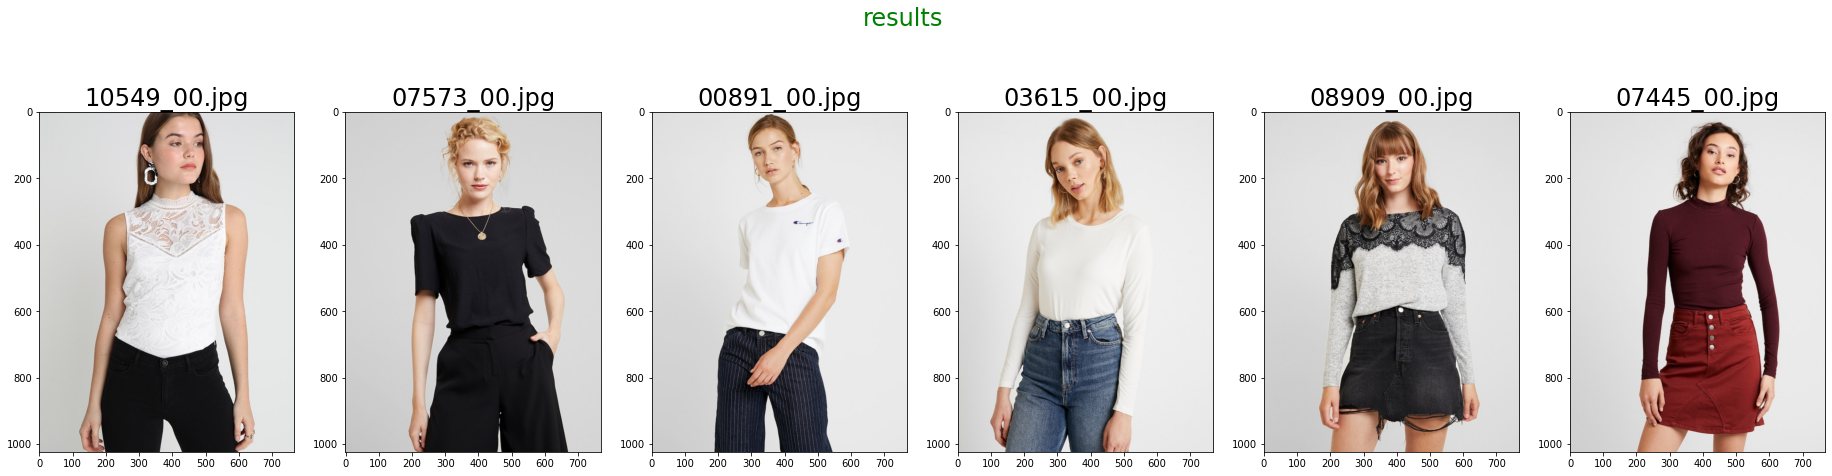

In [326]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from PIL import Image
import os.path as osp

def show_imgs(imgs, horizon=True, h=32, w=8):
    plt.figure(figsize=(h, w), dpi=72)
    plt.suptitle("results", fontsize=24, color='green')
    for i, img in enumerate(imgs):
        if horizon:
            sub_plt = plt.subplot(1, len(imgs), i+1)
        else:
            sub_plt = plt.subplot(len(imgs), 1, i+1)
        _, img_name = img.rsplit('/', 1)
        img = cv2.imread(img)
        sub_plt.imshow(img[:,:,::-1])
        sub_plt.set_title(img_name, fontsize=24)

img_root_dir = Path('./datasets')
imgs = [ str(i) for i in img_root_dir.glob('./test/image/*.jpg')]
print(f'img list: {imgs}')

show_imgs(imgs)

In [327]:
import torch
import torch.nn as nn

class opt:
    name = 'demo'
    batch_size = 1
    workers = 1
    load_height = 1024
    load_width = 768
    shuffle = False
    dataset_dir = './datasets/'
    dataset_mode = 'test'
    dataset_list = 'test/test_pairs.txt'
    checkpoint_dir = './checkpoints/'
    save_dir = './results/'
    display_freq = 1
    seg_checkpoint = 'seg_final.pth'
    gmm_checkpoint = 'gmm_final.pth'
    alias_checkpoint = 'alias_final.pth'
    
    # human-parsing map classes
    semantic_nc = 13
    init_type = 'xavier'
    init_variance = 0.02
    


In [362]:
from datasets import VITONDataset, VITONDataLoader
test_dataset = VITONDataset(opt)
test_loader = VITONDataLoader(opt, test_dataset)

/root/miniconda3/envs/jia/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [363]:
print(f"dataset path: {test_dataset.data_path}")
print(f"dataset images names: {test_dataset.img_names}")
print(f"dataset cloth names: {test_dataset.c_names}")
print(f"img H: {test_dataset.load_height} img W: {test_dataset.load_width}")
print(f"human parsing label nums: {test_dataset.semantic_nc}")

dataset path: ./datasets/test
dataset images names: ['08909_00.jpg', '00891_00.jpg', '03615_00.jpg', '07445_00.jpg', '07573_00.jpg', '10549_00.jpg']
dataset cloth names: {'unpaired': ['02783_00.jpg', '01430_00.jpg', '09933_00.jpg', '06429_00.jpg', '11791_00.jpg', '01260_00.jpg']}
img H: 1024 img W: 768
human parsing label nums: 13


In [370]:
test_dataset[0].keys()

dict_keys(['img_name', 'c_name', 'img', 'img_agnostic', 'parse_agnostic', 'pose', 'cloth', 'cloth_mask'])

## 拆解 Dataset 步骤
* **目的:** 得到 Agnostic Parsing and Agnostic Image

(768, 1024)


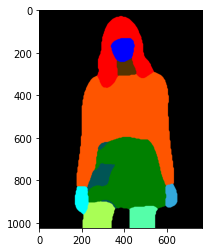

In [470]:
image_name = '08909_00'
parse = Image.open(f'./datasets/test/image-parse/{image_name}.png')
parse = transforms.Resize(test_dataset.load_width, interpolation=0)(parse)
print(parse.size)
plt.imshow(parse)

In [471]:
# get pose_data from openpose-json
import json
with open(f'./datasets/test/openpose-json/{image_name}_keypoints.json', 'r') as f:
    pose_label = json.load(f)
    pose_data = pose_label['people'][0]['pose_keypoints_2d']
    pose_data = np.array(pose_data)
    # opense pose 指示图: https://github.com/jiaqianjing/openpose/blob/master/doc/02_output.md#ui-and-visual-output
    pose_data = pose_data.reshape((-1, 3))[:,:2] # [25, 2], 即 25 个姿势关键点的坐标 (x, y)
    print(pose_data)

[[383.109 173.431]
 [400.163 346.186]
 [264.105 351.907]
 [235.708 592.768]
 [201.727 816.64 ]
 [544.627 337.691]
 [575.685 561.63 ]
 [612.605 805.24 ]
 [419.793 666.483]
 [343.337 666.481]
 [272.551 910.134]
 [  0.      0.   ]
 [496.453 669.285]
 [502.094 915.848]
 [  0.      0.   ]
 [351.99  147.842]
 [414.237 144.927]
 [326.338 167.635]
 [456.725 147.901]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]]


parse_agnostic size: (768, 1024)
torch.Size([1, 1024, 768])


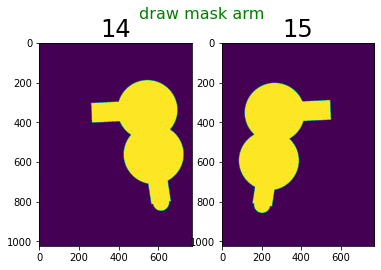

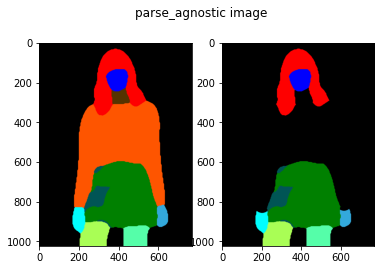

In [472]:
# ========================================================================
# pose_data: 根据 openpose 得到姿态关键点的坐标（25 个关键点）
# parse: PGN-humanparsing 语义分割图（P 模式的 8 bit 调色板图）
# ========================================================================
def get_parse_agnostic(load_width: int, load_height: int, parse: Image, pose_data: np.array):
    """
    human parsing label:
        0 background    10 tosor-skin
        1 hat           11 scarf
        2 hair          12 skirt
        3 glove         13 face
        4 sunglasses    14 leftArm
        5 upperclothes  15 rightArm
        6 dress         16 leftLeg
        7 coat          17 rightLeg
        8 socks         18 leftShoe
        9 pants         19 rightShoe
    """
    parse_array = np.array(parse)
    parse_upper = ((parse_array == 5).astype(np.float32) +
                   (parse_array == 6).astype(np.float32) +
                   (parse_array == 7).astype(np.float32))
    parse_neck = (parse_array == 10).astype(np.float32)

    r = 10
    agnostic = parse.copy()

    # mask arms (移除左右手臂)
    for parse_id, pose_ids in [(14, [2, 5, 6, 7]), (15, [5, 2, 3, 4])]:
        mask_arm = Image.new('L', (load_width, load_height), 'black')
        # 2D 编辑图像函数, 用于编辑上面创建 mask_arm 图片
        mask_arm_draw = ImageDraw.Draw(mask_arm)
        i_prev = pose_ids[0]
        for i in pose_ids[1:]:
            if (pose_data[i_prev, 0] == 0.0 and pose_data[i_prev, 1] == 0.0) or (pose_data[i, 0] == 0.0 and pose_data[i, 1] == 0.0):
                continue
            mask_arm_draw.line([tuple(pose_data[j]) for j in [i_prev, i]], 'white', width=r*10)
            pointx, pointy = pose_data[i]
            radius = r*4 if i == pose_ids[-1] else r*15
            mask_arm_draw.ellipse((pointx-radius, pointy-radius, pointx+radius, pointy+radius), 'white', 'white')
            i_prev = i
            
        # 可视化手臂的涂抹画板
        plt.suptitle("draw mask arm", fontsize=16, color='green')
        draw_plot = plt.subplot(1, 2, parse_id-13)         
        draw_plot.set_title(parse_id, fontsize=24)
        draw_plot.imshow(mask_arm)
        
        
        # 取 mask_arm（不含手的信息） 和 human parsing 左右手臂（含手的信息）交集的部分（为了保留手的信息）
        parse_arm = (np.array(mask_arm) / 255) * (parse_array == parse_id).astype(np.float32)
        
        # 可视化最终要 mask 的手臂部分
        # plt.suptitle("mask arm", fontsize=16, color='green')
        # mask_plot = plt.subplot(1, 2, parse_id-13)
        # mask_plot.set_title(parse_id, fontsize=24)
        # mask_plot.imshow(Image.fromarray(np.uint8(parse_arm * 255), 'L'))
       
        
        agnostic.paste(0, None, Image.fromarray(np.uint8(parse_arm * 255), 'L'))

    # mask torso & neck (移除 humanparsing 的上身躯干和脖子) 
    # im 为要复制的图像（全黑），仅对 mask 中为 255 像素值的位置进行复制，为 0 像素值的位置，保持原图
    agnostic.paste(im=0, box=None, mask=Image.fromarray(np.uint8(parse_upper * 255), 'L'))
    agnostic.paste(im=0, box=None, mask=Image.fromarray(np.uint8(parse_neck * 255), 'L'))

    return agnostic

# =======================================================
# 获取 agnostic 语义分割图；移除手臂、脖子、上身躯干（保留手）
# =======================================================
parse_agnostic = get_parse_agnostic(768, 1024, parse, pose_data)
print(f'parse_agnostic size: {parse_agnostic.size}')

new_fig = plt.figure()
plt.suptitle("parse_agnostic image")
plt.subplot(1, 2, 1)
plt.imshow(parse)
plt.subplot(1, 2, 2)
plt.imshow(parse_agnostic)
parse_agnostic = torch.from_numpy(np.array(parse_agnostic)[np.newaxis,:]).long()
print(parse_agnostic.shape)

In [473]:
# ========================================================================
# Human Parsing(num_class=20) -> VITON Parsing (num_class=13) & One-Hot
# ========================================================================
labels = {
    0: ['background', [0, 10]],  # background, tosor-skin
    1: ['hair', [1, 2]],         # hat, hair
    2: ['face', [4, 13]],        # sunglasses, face
    3: ['upper', [5, 6, 7]],     # upperclothes, dress, coat
    4: ['bottom', [9, 12]],      # pants, skirt
    5: ['left_arm', [14]],       # leftArm
    6: ['right_arm', [15]],      # rightArm
    7: ['left_leg', [16]],       # leftLeg
    8: ['right_leg', [17]],      # rightLeg
    9: ['left_shoe', [18]],      # leftShoe
    10: ['right_shoe', [19]],    # rightShoe
    11: ['socks', [8]],          # socks
    12: ['noise', [3, 11]]       # glove, scarf
}
# [20, 1024, 768] 
parse_agnostic_map = torch.zeros(20, test_dataset.load_height, test_dataset.load_width, dtype=torch.float)
parse_agnostic_map.scatter_(0, parse_agnostic, 1.0)

# [13, 1024, 768]
new_parse_agnostic_map = torch.zeros(test_dataset.semantic_nc, test_dataset.load_height, test_dataset.load_width, dtype=torch.float)
for i in range(len(labels)):
    for label in labels[i][1]:
        new_parse_agnostic_map[i] += parse_agnostic_map[label]

new_parse_agnostic_map.shape

torch.Size([13, 1024, 768])

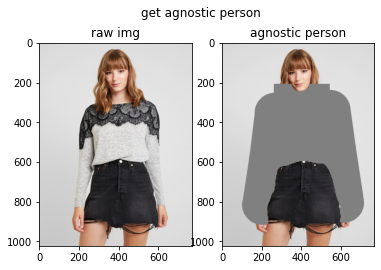

In [482]:
# ========================================================================
# 获取 agnostic person img
# ========================================================================
def get_img_agnostic(img, parse, pose_data):
    """
    human parsing label:
        0 background    10 tosor-skin
        1 hat           11 scarf
        2 hair          12 skirt
        3 glove         13 face
        4 sunglasses    14 leftArm
        5 upperclothes  15 rightArm
        6 dress         16 leftLeg
        7 coat          17 rightLeg
        8 socks         18 leftShoe
        9 pants         19 rightShoe
    """
    parse_array = np.array(parse)
    parse_head = ((parse_array == 4).astype(np.float32) +
                  (parse_array == 13).astype(np.float32))
    parse_lower = ((parse_array == 9).astype(np.float32) +
                   (parse_array == 12).astype(np.float32) +
                   (parse_array == 16).astype(np.float32) +
                   (parse_array == 17).astype(np.float32) +
                   (parse_array == 18).astype(np.float32) +
                   (parse_array == 19).astype(np.float32))

    r = 20
    agnostic = img.copy()
    agnostic_draw = ImageDraw.Draw(agnostic)

    length_a = np.linalg.norm(pose_data[5] - pose_data[2], ord=2) # l2 范数 (两点距离)
    length_b = np.linalg.norm(pose_data[12] - pose_data[9], ord=2) # l2 范数 (两点距离)
    point = (pose_data[9] + pose_data[12]) / 2
    pose_data[9] = point + (pose_data[9] - point) / length_b * length_a
    pose_data[12] = point + (pose_data[12] - point) / length_b * length_a

    # mask arms
    agnostic_draw.line([tuple(pose_data[i]) for i in [2, 5]], 'gray', width=r*10)
    for i in [2, 5]:
        pointx, pointy = pose_data[i]
        agnostic_draw.ellipse((pointx-r*5, pointy-r*5, pointx+r*5, pointy+r*5), 'gray', 'gray')
    
    for i in [3, 4, 6, 7]:
        if (pose_data[i - 1, 0] == 0.0 and pose_data[i - 1, 1] == 0.0) or (pose_data[i, 0] == 0.0 and pose_data[i, 1] == 0.0):
            continue
        agnostic_draw.line([tuple(pose_data[j]) for j in [i - 1, i]], 'gray', width=r*10)
        pointx, pointy = pose_data[i]
        agnostic_draw.ellipse((pointx-r*5, pointy-r*5, pointx+r*5, pointy+r*5), 'gray', 'gray')

    # mask torso
    for i in [9, 12]:
        pointx, pointy = pose_data[i]
        agnostic_draw.ellipse((pointx-r*3, pointy-r*6, pointx+r*3, pointy+r*6), 'gray', 'gray')
    agnostic_draw.line([tuple(pose_data[i]) for i in [2, 9]], 'gray', width=r*6)
    agnostic_draw.line([tuple(pose_data[i]) for i in [5, 12]], 'gray', width=r*6)
    agnostic_draw.line([tuple(pose_data[i]) for i in [9, 12]], 'gray', width=r*12)
    agnostic_draw.polygon([tuple(pose_data[i]) for i in [2, 5, 12, 9]], 'gray', 'gray')

    # mask neck
    pointx, pointy = pose_data[1]
    agnostic_draw.rectangle((pointx-r*7, pointy-r*7, pointx+r*7, pointy+r*7), 'gray', 'gray')
    agnostic.paste(img, None, Image.fromarray(np.uint8(parse_head * 255), 'L'))
    agnostic.paste(img, None, Image.fromarray(np.uint8(parse_lower * 255), 'L'))

    return agnostic

img = Image.open(f'./datasets/test/image/{image_name}.jpg')   
img = transforms.Resize(test_dataset.load_width, interpolation=2)(img)

plt.suptitle("get agnostic person")
plt.subplot(1,2,1)
plt.title("raw img")
plt.imshow(img)
img_agnostic = get_img_agnostic(img, parse, pose_data)
plt.subplot(1,2,2)
plt.title("agnostic person")
plt.imshow(img_agnostic)

## 浏览 dataset 单个数据

In [485]:
img_name = test_dataset[0]['img_name']
c_name = test_dataset[0]['c_name']
img_agnostic = test_dataset[0]['img_agnostic']
parse_agnostic = test_dataset[0]['parse_agnostic']
pose = test_dataset[0]['pose']
cloth = test_dataset[0]['cloth']
cloth_mask = test_dataset[0]['cloth_mask']

In [486]:
print(f'img_name: {img_name}')
print(f'c_name: {c_name}')
print(f'img size: {img.size}')
print(f'img_agnostic shape: {parse_agnostic.shape}')
print(f'pose rgb: {pose.shape}')
print(f'cloth: {cloth}')
print(f'cloth_mask: {cloth_mask}')

img_name: 08909_00.jpg
c_name: {'unpaired': '02783_00.jpg'}
img size: (768, 1024)
parse_agnostic: torch.Size([13, 1024, 768])
pose: torch.Size([3, 1024, 768])
cloth: {'unpaired': tensor([[[0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
         [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
         [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
         ...,
         [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
         [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
         [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294]],

        [[0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
         [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
         [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
         ...,
         [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
         [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
         [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294]],

        [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'cloth_mask')

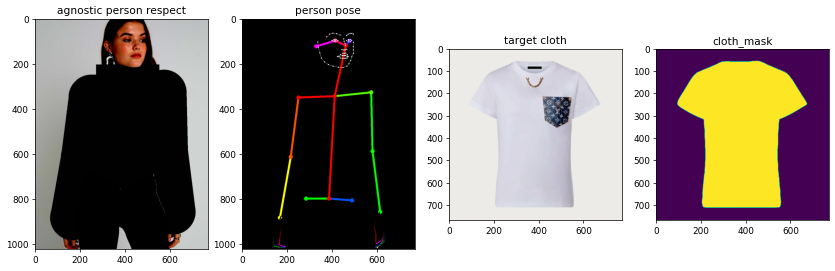

In [74]:
# plt.suptitle('agnostic person respect', size=12)
# plt.imshow(img_agnostic.permute(1,2,0))

figure = plt.figure(figsize=(16, 12), dpi=64)
subplot = figure.add_subplot(1,4,1)
subplot.imshow(img_agnostic.permute(1,2,0))
subplot.set_title("agnostic person respect")

subplot = figure.add_subplot(1,4,2)
subplot.imshow(pose.permute(1,2,0))
subplot.set_title("person pose")

subplot = figure.add_subplot(1,4,3)
subplot.imshow(cloth['unpaired'].permute(1,2,0))
subplot.set_title("target cloth")

subplot = figure.add_subplot(1,4,4)
subplot.imshow(cloth_mask['unpaired'].permute(1,2,0))
subplot.set_title("cloth_mask")

In [26]:
from PIL import Image
import numpy as np

test_clo = Image.open('./datasets/test/cloth/00001.jpg')
print(test_clo)
test_clo_resize = transforms.Resize(opt.load_width, interpolation=transforms.InterpolationMode.BILINEAR)(test_clo)
print(test_clo_resize)
np.array(test_clo_resize).shape

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1012x1006 at 0x7F6933E43B50>
<PIL.Image.Image image mode=RGBA size=772x768 at 0x7F6933E43650>


(768, 772, 4)

In [27]:
test_pose_rgb = Image.open('./datasets/test/openpose-img/10549_00_rendered.png')
print(test_pose_rgb)
test_pose_rgb = transforms.Resize(opt.load_width, interpolation=transforms.InterpolationMode.BILINEAR)(test_pose_rgb)
np.array(test_pose_rgb).shape

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x1024 at 0x7F6933EBCA90>


(1024, 768, 3)

In [28]:
import json
with open('./datasets/test/openpose-json/10549_00_keypoints.json', 'r') as f:
    pose_label = json.load(f)
    pose_data = pose_label['people'][0]['pose_keypoints_2d']

pose_data = np.array(pose_data)
print(len(pose_data))
pose_data = pose_data.reshape((-1, 3))[:,:2]
print(len(pose_data))
print(pose_data)

75
25
[[459.603  122.451 ]
 [411.401  346.153 ]
 [249.916  351.895 ]
 [215.989  615.463 ]
 [167.622  884.65  ]
 [572.918  329.283 ]
 [578.538  589.933 ]
 [612.648  859.15  ]
 [385.91   799.624 ]
 [283.837  799.646 ]
 [  0.       0.    ]
 [  0.       0.    ]
 [487.878  808.134 ]
 [  0.       0.    ]
 [  0.       0.    ]
 [414.199   99.5305]
 [479.445   99.5607]
 [329.24   125.332 ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]]


## Huamn parsing(part segmentation)

1
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  76  76  76  76  76  76  76  76   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  76  76  76  29  29  29  29  29  76   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  76  76  76  29  29  29  29  29  29  76   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  76  76  76  29  29  29  29  29  29  29   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  76  76  29  29  29  29  29  29  29  29  76   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  29  76  29  29  29  29  29  29  29  29  76   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   

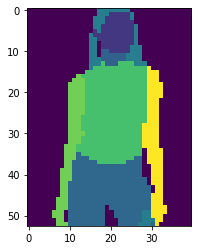

In [29]:
# load demo parsing image
parse = Image.open('./datasets/test/image-parse/08909_00.png').convert('L')

print(len(parse.split()))

#parse = transforms.Resize(opt.load_width, interpolation=transforms.InterpolationMode.NEAREST)(parse)
parse = transforms.Resize(40, interpolation=transforms.InterpolationMode.NEAREST)(parse)

parse_array = np.array(parse)

np.set_printoptions(edgeitems=50, linewidth=200)
print(parse_array)
print(parse_array.shape)
plt.imshow(parse_array)

In [136]:
CIHP_CLASSES = ['background', 'hat', 'hair', 'glove', 'sunglasses', 'upperclothes',
               'dress', 'coat', 'socks', 'pants', 'tosor-skin', 'scarf', 'skirt',
               'face', 'leftArm', 'rightArm', 'leftLeg', 'rightLeg', 'leftShoe', 'rightShoe']
for k, v in enumerate(CIHP_CLASSES):
    print(k, v)

0 background
1 hat
2 hair
3 glove
4 sunglasses
5 upperclothes
6 dress
7 coat
8 socks
9 pants
10 tosor-skin
11 scarf
12 skirt
13 face
14 leftArm
15 rightArm
16 leftLeg
17 rightLeg
18 leftShoe
19 rightShoe


In [90]:
viton_classes = {
            0: ['background', [0, 10]],  # background, tosor-skin
            1: ['hair', [1, 2]],         # hat, hair
            2: ['face', [4, 13]],        # sunglasses, face
            3: ['upper', [5, 6, 7]],     # upperclothes, dress, coat
            4: ['bottom', [9, 12]],      # pants, skirt
            5: ['left_arm', [14]],       # leftArm
            6: ['right_arm', [15]],      # rightArm
            7: ['left_leg', [16]],       # leftLeg
            8: ['right_leg', [17]],      # rightLeg
            9: ['left_shoe', [18]],      # leftShoe
            10: ['right_shoe', [19]],    # rightShoe
            11: ['socks', [8]],          # socks
            12: ['noise', [3, 11]]       # glove, scarf
        }

In [91]:
# by Demo Input human parsing (附带了调色板信息的图片)
from PIL import Image
import numpy as np
test_parse_path = 'datasets/test/image-parse-bak/10549_00.png'
parse = Image.open(test_parse_path)
parse_a = np.asarray(parse)
print("parse_a shape:", parse_a.shape)
print(parse.mode, parse.info, parse.palette)

parse_a shape: (1024, 768)
P {} <PIL.ImagePalette.ImagePalette object at 0x7fa35763f890>


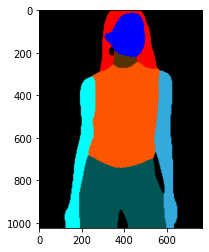

In [92]:
color_map = parse.getpalette()
plt.imshow(parse)

In [93]:
# color_map is list, len： 768 = 3 channel * 256 gray value
len(color_map)

768

In [94]:
print(color_map)

[0, 0, 0, 128, 0, 0, 254, 0, 0, 0, 85, 0, 169, 0, 51, 254, 85, 0, 0, 0, 85, 0, 119, 220, 85, 85, 0, 0, 85, 85, 85, 51, 0, 52, 86, 128, 0, 128, 0, 0, 0, 254, 51, 169, 220, 0, 254, 254, 85, 254, 169, 169, 254, 85, 254, 254, 0, 254, 169, 0, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 46, 47, 47, 47, 48, 48, 48, 49, 49, 49, 50, 50, 50, 51, 51, 51, 52, 52, 52, 53, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 59, 59, 59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64, 64, 64, 65, 65, 65, 66, 66, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, 70, 70, 70, 71, 71, 71, 72, 72, 72, 73, 73, 73, 74, 74, 74, 75, 75, 75, 76, 76, 76, 77, 77, 77, 78, 78, 78, 79, 79, 79, 80, 80, 80, 81, 81, 81, 82, 82, 82, 83, 83

In [95]:
import pickle
with open('colormap.pkl', 'wb') as file:    #注意二进制写入
    pickle.dump(color_map, file)


In [97]:
# by CIHP-PGN inference （没有调色板信息的图片）
test_parse_path = 'datasets/test/image-parse/08909_00.png'
parse_02 = Image.open(test_parse_path).convert('L')
parse_02_a = np.asarray(parse_02)
print("parse_02_a shape:", parse_02_a.shape)
print(parse_02.mode, parse_02.info, parse_02.getpalette())

parse_02_a shape: (1024, 768)
L {} None


In [98]:
# difference ratio
(parse_a != parse_02_a).astype(np.int32).reshape([-1]).sum()/len(parse_a.reshape([-1]))

0.49635950724283856

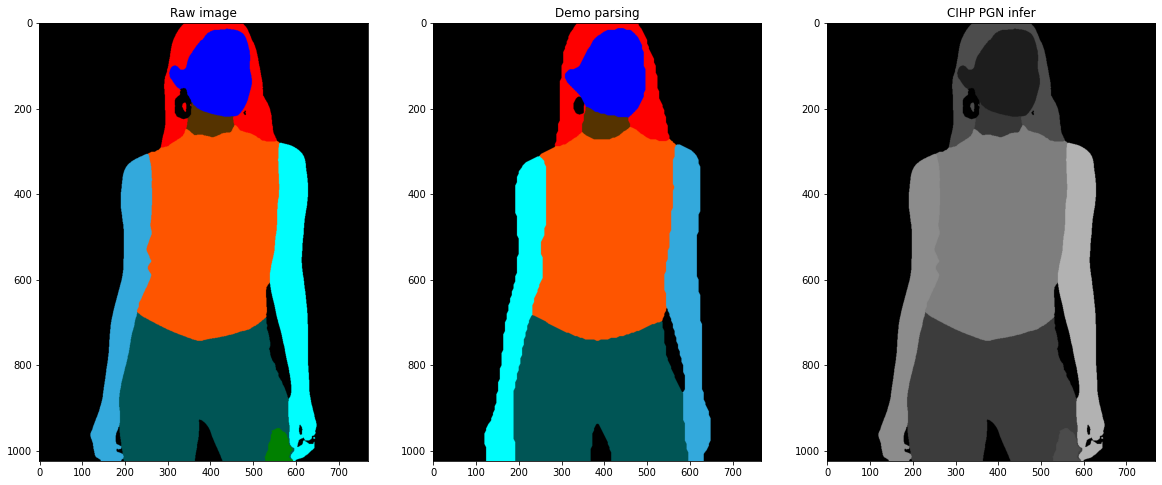

In [99]:
# 添加调色板信息，显示图片
parse_02.putpalette(color_map)
plt.figure(figsize=(20, 10), dpi=72)
plt.subplot(1,3,1)
plt.title('Raw image')
plt.imshow(Image.open(test_parse_path))
plt.subplot(1,3,2)
plt.title("Demo parsing")
plt.imshow(parse)
plt.subplot(1,3,3)
plt.title("CIHP PGN infer")
plt.imshow(parse_02)

L <bound method Image.getpalette of <PIL.Image.Image image mode=L size=768x1024 at 0x7FA35725FB90>>


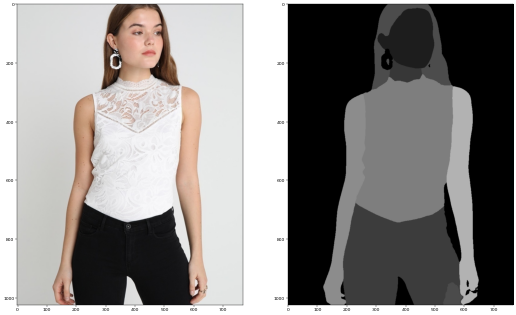

In [110]:
test = Image.open('./datasets/test/image-parse/08909_00.png').convert('L')
print(test.mode, test.getpalette)
test.putpalette(color_map)
plt.figure(figsize=(20,15), dpi=32)
plt.subplot(1,2,1)
plt.imshow(Image.open('./datasets/test/image/08909_00.jpg'))
plt.subplot(1,2,2)
plt.imshow(test)

## openpose

In [103]:
import json
with open('./datasets/test/openpose-json/10549_00_keypoints.json', 'r', encoding='utf-8') as f:
    key_points = json.load(f)

In [104]:
key_points['people'][0].keys()

dict_keys(['person_id', 'pose_keypoints_2d', 'face_keypoints_2d', 'hand_left_keypoints_2d', 'hand_right_keypoints_2d', 'pose_keypoints_3d', 'face_keypoints_3d', 'hand_left_keypoints_3d', 'hand_right_keypoints_3d'])

In [105]:
# point format: x, y, confidence
print(key_points['people'][0]['pose_keypoints_2d'][:6])

# total keypoints: 25; 
print(len(key_points['people'][0]['pose_keypoints_2d'])/3)

[459.603, 122.451, 0.925407, 411.401, 346.153, 0.745393]
25.0


In [106]:
pose_img = Image.open('./datasets/test/openpose-img/10549_00_rendered.png')
pose_img.mode, pose_img.format

('RGB', 'PNG')

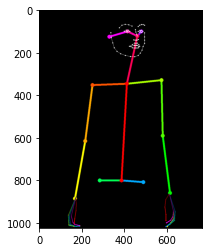

In [107]:
plt.imshow(pose_img)

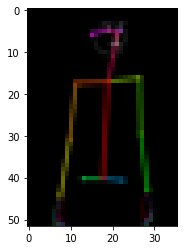

In [108]:
pose_img_re = pose_img.resize((36, 52))
plt.imshow(pose_img_re)

In [109]:
np.set_printoptions(edgeitems=600, linewidth=600)
pose_img_re_a = np.asarray(pose_img_re)
print(pose_img_re_a.shape)
print(pose_img_re_a[:,:,0])

(52, 36, 3)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   8  24  19  13  10  36  14   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   7  27  75   9  22  58   3   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1  43  65 103 119 138 115 116 115  14   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  11 153  80  27   0   0  31 173  20  16   0   0 

In [ ]:
print(pose_img_re_a[:,:,1])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   8  25  22  13  10  38  14   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  12  15  39  11  28  36   2   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  15   5   0  14  46   5  44  55  15   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  15   8   0   0   0   4  25   6  18   0   0   0   0   0 

In [ ]:
print(pose_img_re_a[:,:,2])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   8  24  20  13  10  35  14   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   7  26  64   9  25  69   3   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1  43  65 104 118 112  76  99 141  14   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  11 153  80  27   0   0  21  83  11  17   0   0   0   0   0 